<a href="https://colab.research.google.com/github/pren1/VAST/blob/master/VTB_classifier_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf VAST/
!git clone https://github.com/pren1/VAST.git
!pip3 install soundfile
!pip3 install librosa

Cloning into 'VAST'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 94 (delta 40), reused 50 (delta 18), pack-reused 0
Unpacking objects: 100% (94/94), done.


In [0]:
from VAST.util import *
import pdb
import pprint
from tqdm import tqdm
import numpy as np
import IPython
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import os

### Prepare dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

# !gdown https://drive.google.com/uc?id=14AT3AGwNtPMRaFGN7VE2rf2BHrN4ImSd
# !gdown https://drive.google.com/uc?id=16124JngZYtz-xt5p_KBdsuo4lXN-TDCW

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Set critical path and parameters

In [0]:
regenerate_data_to_folder = False

debug_name_list = ['宝鐘マリン', '白上フブキ', '天音かなた', '夏色まつり']
save_path = "gdrive/My Drive/Free_RAM_VAST/"
sub_size = 512
train_ratio = 0.8
batch_size = 2048
dim = 8000 
sample_rate = 8000
n_classes = 4
'How many sub_batch should we use for each vtb?'
sub_value = int(batch_size/(n_classes * sub_size))
dropout_rate = 0.1

### We save the data as some batches

In [0]:
def split_data_into_folders(debug_name_list, save_path, Batch_size):
  'Save data in a special way'
  data, label = load_data()
  label_list = set(label)
  assert len(label_list) == len(debug_name_list)
  create_folders(save_path)
  whole_label = np.asarray(label)
  for single in label_list:
    whole_index = np.where(label == single)[0]
    save_split_small_batch(data[whole_index], whole_label[whole_index], save_path + f"{debug_name_list[single]}/", Batch_size)

def load_data():
  'Just load data, be careful about your RAM'
  data_folder = "gdrive/My Drive/CLIPPED_VAST/"
  label_folder = "gdrive/My Drive/CLIPPED_VAST/"
  data = []
  label = []
  for i in tqdm(range(6)):
    data.append(load_data_array_from_npy(data_folder + f"dataset_{i}.npy"))
    label.extend(load_data_array_from_npy(label_folder + f"labelset_{i}.npy"))

  # data.append(load_data_array_from_npy(data_folder + f"add_data.npy"))
  # label.extend(load_data_array_from_npy(label_folder + f"add_label.npy"))
  data = np.vstack(data)
  return data, label

def save_split_small_batch(target_data, target_label, save_path, Batch_size = 128):
  'save data, each npy file contains Batch_size seq of data'
  save_index = 0
  create_folders(save_path)
  for index in tqdm(range(0, len(target_label), Batch_size)):
    data_clip = target_data[index:index + Batch_size]
    label_clip = target_label[index:index + Batch_size]
    if len(data_clip) == Batch_size:
      'save data'
      save_data_array_as_npy(data_clip, save_path + f'data_{save_index}')
      save_data_array_as_npy(label_clip, save_path + f'label_{save_index}')
      save_index += 1

In [0]:
if regenerate_data_to_folder:
  split_data_into_folders(debug_name_list = debug_name_list, save_path = save_path, Batch_size = sub_size)

### Take a look at the loaded data

In [0]:
# for i in range(3):
#   plt.plot(data[i], color = 'orange', label='read in sample data')
#   plt.title(f"Label: {label[i]}")
#   plt.show()
#   IPython.display.display(IPython.display.Audio(np.asarray(data[i]).T, rate=8000))

### See if the preprocess part works correct

In [0]:
# from keras.models import Sequential
# from kapre.time_frequency import Melspectrogram, Spectrogram
# from kapre.utils import Normalization2D

# melspecModel = Sequential() 

# melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, data.shape[-1]),
#                          padding='same', sr=sample_rate, n_mels=80,
#                          fmin=40.0, fmax=sample_rate/2, power_melgram=1.0,
#                          return_decibel_melgram=True, trainable_fb=False,
#                          trainable_kernel=False,
#                          name='mel_stft') )

# melspecModel.add(Normalization2D(int_axis=0))

# melspecModel.summary()

In [0]:
# test_input = np.expand_dims(np.expand_dims(data[0], 0), 0)
# print(f"test_input shape: {test_input.shape}")
# melspec = melspecModel.predict(test_input)
# print(f"melspec shape: {melspec.shape}")

# plt.figure(figsize=(17,6))
# plt.pcolormesh(melspec[0,:,:,0])

# plt.title('Spectrogram visualization')
# plt.ylabel('Frequency')
# plt.xlabel('Time')

# plt.show()

### Check if mel spectrogram matches the one computed with librosa

In [0]:
# librosa_melspec = librosa.feature.melspectrogram(y=data[0], sr=sample_rate, n_fft=1024,
#                                                  hop_length=128, power=1.0, #window='hann',
#                                                  n_mels=80, fmin=40.0, fmax=sample_rate/2)
# S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)
# plt.figure(figsize=(17,6))
# plt.pcolormesh(S_dB)

# plt.title('Spectrogram visualization - librosa')
# plt.ylabel('Frequency')
# plt.xlabel('Time')

# plt.show()

### A toy CNN + LSTM + attention classifier 

In [11]:
from keras import layers as L
import keras.backend as K
from keras.models import Model
from keras.callbacks import LearningRateScheduler
import math
import keras
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

'define model'
def AttRNNSpeechModel(nCategories, dropout_rate, samplingrate=8000,
                      inputLength=8000, rnn_func=L.LSTM):
    # simple LSTM
    sr = samplingrate
    iLen = inputLength
    dropout_rate = dropout_rate

    inputs = L.Input((inputLength,), name='input')

    x = L.Reshape((1, -1))(inputs)

    m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                       padding='same', sr=sr, n_mels=80,
                       fmin=40.0, fmax=sr / 2, power_melgram=1.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='mel_stft')
    m.trainable = False

    x = m(x)

    x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)

    # note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    # we would rather have it the other way around for LSTMs

    x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(dropout_rate)(x)
    
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(dropout_rate)(x)

    # x = Reshape((125, 80)) (x)
    # keras.backend.squeeze(x, axis)
    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]
    
    x = L.Dropout(dropout_rate)(x)                    
    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]

    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    query = L.Dense(128)(xFirst)

    # dot product attention
    attScores = L.Dot(axes=[1, 2])([query, x])
    attScores = L.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # rescale sequence
    attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

    x = L.Dense(64, activation='relu')(attVector)
    x = L.Dense(32)(x)

    output = L.Dense(nCategories, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs], outputs=[output])

    return model

'learning rate decay'
def step_decay(self, epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate    

Using TensorFlow backend.


In [12]:
model = AttRNNSpeechModel(n_classes, dropout_rate=dropout_rate, samplingrate=sample_rate, inputLength=dim)
model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['categorical_accuracy'])
model.summary()
lrate = LearningRateScheduler(step_decay)

tracking <tf.Variable 'mel_stft/real_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_real_kernels
tracking <tf.Variable 'mel_stft/imag_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_imag_kernels
tracking <tf.Variable 'mel_stft/Variable:0' shape=(513, 80) dtype=float32> freq2mel
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 8000)         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 8000)      0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, 63, 1)    1091664     reshape_1[0][0]                 

### Define data generator

In [0]:
class reiterate_list():
  'Iterate over the id list provided'
  def __init__(self, ID_list, return_number, is_shuffle=True):
    self.ID_list = np.asarray(ID_list)
    self.list_length = len(self.ID_list)
    self.return_number = return_number
    self.order = np.arange(self.list_length)
    self.shuffled = False
    self.cursor = 0
    if is_shuffle:
        self.shuffle()

  def shuffle(self):
      np.random.shuffle(self.order)
      self.cursor = 0

  def next(self):
      if self.shuffled==True:
          self.shuffled = False
      if self.cursor + self.return_number > self.list_length:
          self.shuffle()
          self.shuffled = True
      idx = self.order[self.cursor:self.cursor + self.return_number]
      self.cursor += self.return_number
      return self.ID_list[idx]

def build_train_test_id_dicts():
  'randomly assign each id to either train set or test set'
  first_level_folders = [f.path.split('/')[-1] for f in os.scandir(save_path) if f.is_dir()]
  assert first_level_folders == debug_name_list, "Saved folder inconsistent, check your code"
  train_dict = {}
  test_dict = {}
  for single_vtb in debug_name_list:
    all_files = files_in_target_folder(save_path + single_vtb, '.npy')
    range_index = np.arange(len(all_files)//2)
    np.random.shuffle(range_index)
    train_dict[single_vtb] = range_index[:int(train_ratio * len(range_index))]
    test_dict[single_vtb] = range_index[int(train_ratio * len(range_index)):]
  return train_dict, test_dict

def DataGenerator(target_dict):
  id_dict = {}
  for single_vtb in target_dict:
    id_dict[single_vtb] = reiterate_list(target_dict[single_vtb], sub_value)
  
  # Create empty arrays to contain batch of features and labels#
  X = np.empty((batch_size, dim))
  y = np.empty((batch_size), dtype=int)
  while True:
    'get a bunch of ids, then read in them'
    data_list = []
    label_list = []
    for single_vtb in id_dict:
      target_id_list = id_dict[single_vtb].next()
      data_list.extend([save_path + single_vtb + "/" + f'data_{ID}.npy' for ID in target_id_list])
      label_list.extend([save_path + single_vtb + "/" + f'label_{ID}.npy' for ID in target_id_list])
      
    'Then, fill in the read in results to X and y'
    for index, (data_path, label_path) in enumerate(zip(data_list, label_list)):
      X[index * sub_size:(index + 1) * sub_size] = load_data_array_from_npy(data_path)
      y[index * sub_size:(index + 1) * sub_size] = load_data_array_from_npy(label_path)
    'To one-hot'
    yield X, keras.utils.to_categorical(y, num_classes=n_classes)

def get_step_from_dictionary(input_dict):
  'When will the whole dataset run out?'
  res = []
  for vtb in input_dict:
    res.append(len(input_dict[vtb])//sub_value)
  return np.max(res)  

def generate_generator():
  train_dict, test_dict = build_train_test_id_dicts()
  train_generator = DataGenerator(train_dict)
  test_generator = DataGenerator(test_dict)
  return train_generator, test_generator, train_dict, test_dict

In [0]:
train_generator, test_generator, train_dict, test_dict = generate_generator()
train_steps = get_step_from_dictionary(train_dict)
validation_steps = get_step_from_dictionary(test_dict)

### Calculate class weights

In [15]:
from sklearn.utils import class_weight
def build_label_for_class_weight_calculation(input_dict):
  label = []
  for index, vtb in enumerate(input_dict):
    label.extend([index] * len(input_dict[vtb]))
  return label  

label = build_label_for_class_weight_calculation(train_dict)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(label),
                                                 label)
class_weights

array([0.82621951, 1.27830189, 0.82621951, 1.25462963])

### Train model

In [23]:
# results = model.fit(x = data[train_idx], y = to_categorical(label[train_idx]),
# 				epochs=30,
# 				batch_size=2048,
# 				shuffle=True,
# 				validation_data=(data[test_idx], to_categorical(label[test_idx])),
# 				callbacks=[lrate],
# 				class_weight=class_weights
# 				)

# Train model on dataset
results = model.fit_generator(generator=train_generator,
                    epochs=20,
										validation_data=test_generator,
										validation_steps = validation_steps,
										steps_per_epoch = train_steps,
										shuffle=True,
										callbacks=[lrate],
										class_weight=class_weights
                    )

Epoch 1/15
82/82 [==============================] - 264s 3s/step - loss: 0.0232 - categorical_accuracy: 0.9917 - val_loss: 0.1008 - val_categorical_accuracy: 0.9750
Epoch 2/15
82/82 [==============================] - 226s 3s/step - loss: 0.0284 - categorical_accuracy: 0.9901 - val_loss: 0.1027 - val_categorical_accuracy: 0.9702
Epoch 3/15
82/82 [==============================] - 251s 3s/step - loss: 0.0233 - categorical_accuracy: 0.9919 - val_loss: 0.0712 - val_categorical_accuracy: 0.9712
Epoch 4/15
82/82 [==============================] - 231s 3s/step - loss: 0.0271 - categorical_accuracy: 0.9905 - val_loss: 0.0804 - val_categorical_accuracy: 0.9734
Epoch 5/15
53/82 [==================>...........] - ETA: 1:10 - loss: 0.0213 - categorical_accuracy: 0.9925

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


82/82 [==============================] - 248s 3s/step - loss: 0.0214 - categorical_accuracy: 0.9925 - val_loss: 0.1097 - val_categorical_accuracy: 0.9763
Epoch 6/15
82/82 [==============================] - 245s 3s/step - loss: 0.0210 - categorical_accuracy: 0.9927 - val_loss: 0.1055 - val_categorical_accuracy: 0.9743
Epoch 7/15
82/82 [==============================] - 231s 3s/step - loss: 0.0227 - categorical_accuracy: 0.9922 - val_loss: 0.1092 - val_categorical_accuracy: 0.9734
Epoch 8/15
82/82 [==============================] - 218s 3s/step - loss: 0.0213 - categorical_accuracy: 0.9924 - val_loss: 0.1352 - val_categorical_accuracy: 0.9756
Epoch 9/15
82/82 [==============================] - 204s 2s/step - loss: 0.0188 - categorical_accuracy: 0.9933 - val_loss: 0.0802 - val_categorical_accuracy: 0.9769
Epoch 10/15
82/82 [==============================] - 222s 3s/step - loss: 0.0177 - categorical_accuracy: 0.9938 - val_loss: 0.0881 - val_categorical_accuracy: 0.9768
Epoch 11/15
82/82 [=

### Training loss/acc curve

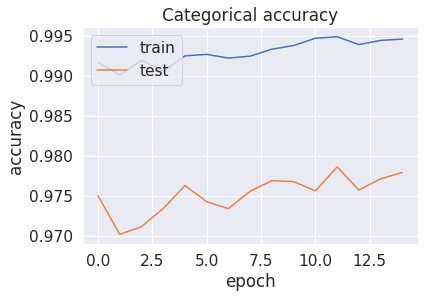

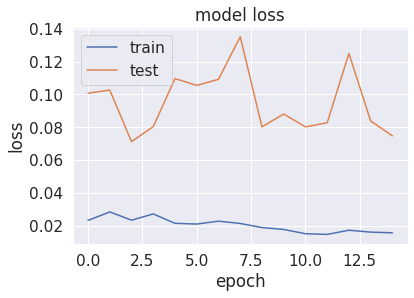

In [24]:
# summarize history for categorical accuracy
plt.plot(results.history['categorical_accuracy'])
plt.plot(results.history['val_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save model

In [0]:
model.save_weights('gdrive/My Drive/four_vtb_classifier_model.h5')

In [26]:
evaluate_model = AttRNNSpeechModel(n_classes, dropout_rate=dropout_rate)
evaluate_model.load_weights('gdrive/My Drive/four_vtb_classifier_model.h5')

tracking <tf.Variable 'mel_stft_2/real_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_real_kernels
tracking <tf.Variable 'mel_stft_2/imag_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_imag_kernels
tracking <tf.Variable 'mel_stft_2/Variable:0' shape=(513, 80) dtype=float32> freq2mel


### Draw confusion matrix

In [27]:
from sklearn.metrics import confusion_matrix
# Get y_pred_test
y_pred = []
y_test = []
for i in tqdm(range(validation_steps)):
  data, label = next(test_generator)
  four_class_probs = evaluate_model.predict(data)
  y_pred.extend(np.argmax(four_class_probs, axis=-1))
  y_test.extend(np.argmax(label, axis=-1))

confusion_mat = confusion_matrix(y_test, y_pred)

100%|██████████| 21/21 [01:40<00:00,  4.80s/it]


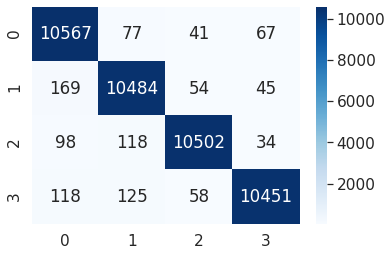

In [28]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_mat, range(confusion_mat.shape[0]), range(confusion_mat.shape[1]))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.show()

In [0]:
# debug_name_list = ['宝鐘マリン', '白上フブキ', '天音かなた', '夏色まつり']

# up_total = 0

# for i in range(len(y_pred)):
#   if up_total == 50:
#     pdb.set_trace()
#   if y_pred[i] != y_test[i]:
#     plt.plot(X_test[i], color = 'orange', label='incorrect data')
#     plt.title(f"pred: {y_pred[i]}, real: {y_test[i]}")
#     plt.show()
#     print(f" 预测: {debug_name_list[y_pred[i]]}, 实际: {debug_name_list[y_test[i]]}")
#     for j in range(4):
#       print(f"{debug_name_list[j]}: {four_class_probs[i][j]}")
#     IPython.display.display(IPython.display.Audio(np.asarray(X_test[i]).T, rate=8000))
#     up_total += 1
    